# XGBoost Baseline - LB 0.678

XGBoost로 18개 질문 각각에 대해 그룹 KFold 모델을 교육합니다.   
CV 점수는 0.678점입니다. KFold 모델 중 하나를 사용하여 테스트를 추론합니다.  
xgboost를 위해 더 많은 기능을 엔지니어링하거나 다른 모델(다른 ML 모델 및/또는 RNN 및/또는 Transformer)을   
시도하여 CV 및 LB를 개선할 수 있습니다. 또한 더 많은 KFold 모델을 사용하거나 모든 데이터(및 KFold 교차 검증에서   
발견한 하이퍼 파라미터)를 사용하여 하나의 모델을 교육하여 LB를 개선할 수 있습니다.  

In [69]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Load Train Data and Labels

In [70]:
train = pd.read_csv('/Users/leebyeongho/Downloads/predict-student-performance-from-game-play/train.csv')
print(train.shape)
train.head()

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991,-159.315,380.000,494.000,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991,-159.315,380.000,494.000,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991,-159.315,380.000,494.000,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991,-159.315,380.000,494.000,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991,-159.315,381.000,494.000,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [40]:
pd.options.display.float_format = '{:.3f}'.format
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   page            float64
 5   room_coor_x     float64
 6   room_coor_y     float64
 7   hover_duration  float64
 8   fqid            object 
 9   room_fqid       object 
 10  text_fqid       object 
 11  level_group     object 
dtypes: float64(4), int64(3), object(5)
memory usage: 1.2+ GB


In [72]:
# 'fullscreen','hq','music' 전부다 결측치여서 컬럼을 삭제
# screen 빼기
# name 날리고
# text 날려
df_train = train.drop(['fullscreen','hq','music','screen_coor_x','screen_coor_y','name','text'], axis=1)

# NaN값처리

- 호버에는 클릭이없으니까 room의 x,y좌표의 결측치 0으로 
- 클릭은 호버가없으니까 hover_duration의 결측치 0으로

In [67]:
df_train.isnull().sum()

session_id                  0
index                       0
elapsed_time                0
event_name                  0
room_coor_x                 0
room_coor_y                 0
hover_duration              0
fqid                  4159648
room_fqid                   0
text_fqid             8367266
level_group                 0
page_-1                     0
page_0                      0
page_1                      0
page_2                      0
page_3                      0
page_4                      0
page_5                      0
page_6                      0
navigate_click              0
person_click                0
cutscene_click              0
object_click                0
map_hover                   0
notification_click          0
map_click                   0
observation_click           0
checkpoint                  0
dtype: int64

In [73]:
df_train['room_coor_x'] = df_train['room_coor_x'].fillna(0)

In [74]:
df_train['room_coor_y'] = df_train['room_coor_y'].fillna(0)

In [75]:
df_train['hover_duration'] = df_train['hover_duration'].fillna(0)

In [76]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

items = train['page'].values

labels = items.reshape(-1,1)

oh_encoder = OneHotEncoder()
oh_encoder.fit(labels)
oh_labels = oh_encoder.transform(labels)
print(oh_labels.toarray())

train_cat = oh_labels.toarray()

tmp_df = pd.DataFrame(train_cat, columns=['page_' + str(col) for col in range(-1,7)])

df_train = pd.concat([df_train.drop(columns=['page'],axis=1),tmp_df],axis=1)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [77]:
df_train

,session_id,index,elapsed_time,event_name,level,room_coor_x,room_coor_y,hover_duration,fqid,room_fqid,text_fqid,level_group,page_-1,page_0,page_1,page_2,page_3,page_4,page_5,page_6
0,20090312431273200,0,0,cutscene_click,0,-413.991,-159.315,0.000,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1,20090312431273200,1,1323,person_click,0,-413.991,-159.315,0.000,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2,20090312431273200,2,831,person_click,0,-413.991,-159.315,0.000,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
3,20090312431273200,3,1147,person_click,0,-413.991,-159.315,0.000,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
4,20090312431273200,4,1863,person_click,0,-412.991,-159.315,0.000,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13174206,22100221145014656,1600,5483231,navigate_click,22,343.887,36.701,0.000,NaN,tunic.capitol_2.hall,NaN,13-22,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
13174207,22100221145014656,1601,5485166,navigate_click,22,332.696,141.493,0.000,chap4_finale_c,tunic.capitol_2.hall,NaN,13-22,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
13174208,22100221145014656,1602,5485917,navigate_click,22,369.913,140.569,0.000,NaN,tunic.capitol_2.hall,NaN,13-22,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
13174209,22100221145014656,1603,5486753,navigate_click,22,252.300,123.806,0.000,chap4_finale_c,tunic.capitol_2.hall,NaN,13-22,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


In [1]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# features = train.columns
# corr_df = train[features].corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(corr_df, annot=True);

In [78]:
targets = pd.read_csv('/Users/leebyeongho/Downloads/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print(targets.shape)
targets.head()

(212022, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


# Columns

session_id - 이벤트가 발생한 세션의 ID  
index - 세션의 이벤트 인덱스  
elapsed_time - 세션 시작과 이벤트가 기록된 시간 사이에 경과된 시간(in milliseconds)  
event_name - 이벤트 유형의 이름  
name - 이벤트 이름(예: notebook_click이 노트북을 열거나 닫는 중인지 식별)  
level - 이벤트가 발생한 게임의 레벨(0~22)  
page - 이벤트의 페이지 번호(노트북 관련 이벤트에만 해당)  
room_coor_x - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
room_coor_y - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_x - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_y - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
hover_duration - 호버가 발생한 시간(in milliseconds)(호버 이벤트에만 해당)  
text - 이 이벤트 동안 플레이어에게 표시되는 텍스트  
fqid - 이벤트의 완전한 ID  
room_fqid - 이벤트가 발생한 방의 정규화된 ID  
text_fqid - 정규화된 ID  
fullscreen - 플레이어가 전체 화면 모드인지 여부  
hq - 게임이 고품질인지 여부  
음악 - 게임 음악이 켜져 있는지 여부  
level_group - 레벨 그룹 및 질문 그룹 - 이 행은 (0-4, 5-12, 13-22)에 속합니다.  

# Feature Engineer

기본적인 Aggregate 기능을 만듭니다. CV와 LB를 강화하기 위해 더 많은 기능을 만들어 보십시오!

In [79]:
OBJECT = ['event_name','fqid', 'room_fqid', 'text_fqid']
NUMS = ['elapsed_time','room_coor_x','level', 'room_coor_y', 'hover_duration']

EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

PAGE = ['page_-1','page_0', 'page_1', 'page_2', 'page_3', 'page_4', 'page_5', 'page_6']

## OBJECT 

event_name - 이벤트 유형의 이름  
name - 이벤트 이름(예: notebook_click이 노트북을 열거나 닫는 중인지 식별)  
fqid - 이벤트의 완전한 ID  
room_fqid - 이벤트가 발생한 방의 정규화된 ID  
text_fqid - 정규화된 ID  
text - 이 이벤트 동안 플레이어에게 표시되는 텍스트  


## NUMS  

elapsed_time - 세션 시작과 이벤트가 기록된 시간 사이에 경과된 시간(밀리초)  
level - 이벤트가 발생한 게임의 레벨(0~22)  
page - 이벤트의 페이지 번호(노트북 관련 이벤트에만 해당)  
room_coor_x - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
room_coor_y - 게임 내 방을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_x - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
screen_coor_y - 플레이어 화면을 기준으로 한 클릭 좌표(클릭 이벤트에만 해당)  
hover_duration - 호버가 발생한 시간(밀리초)(호버 이벤트에만 해당)  

## 안 쓴 특성   
index - 세션의 이벤트 인덱스  
fullscreen - 플레이어가 전체 화면 모드인지 여부  
hq - 게임이 고품질인지 여부  
음악 - 게임 음악이 켜져 있는지 여부  

## feature_engineer
level_group - 레벨 그룹 및 질문 그룹 - 이 행은 (0-4, 5-12, 13-22)에 속합니다.  
session_id - 이벤트가 발생한 세션의 ID  

In [80]:
def feature_engineer(train):
    
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in PAGE:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
        
    df = pd.concat(dfs,axis=1)
    # df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [81]:
%%time
df = feature_engineer(df_train)
print(df.shape)
df.head()

(35337, 33)
CPU times: user 31.5 s, sys: 1.17 s, total: 32.7 s
Wall time: 32.9 s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time_mean,room_coor_x_mean,level_mean,room_coor_y_mean,hover_duration_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,17,85793.558,7.281,1.945,-67.518,115.855,...,81.000,22.000,28.000,11.000,4.000,8,2.000,4,1,14155937
20090312431273200,13-22,10,49,12,35,1040600.767,-121.657,17.402,-151.204,57.852,...,170.000,123.000,60.000,20.000,14.000,10,6.000,3,1,437052322
20090312431273200,5-12,10,39,11,24,357205.189,12.808,8.054,-51.272,98.243,...,103.000,104.000,12.000,28.000,9.000,9,8.000,1,1,105732736
20090312433251036,0-4,11,22,6,11,97633.417,-78.604,1.871,-50.196,79.353,...,49.000,18.000,36.000,15.000,3.000,5,3.000,2,1,13571045
20090312433251036,13-22,11,73,16,43,2498852.223,-24.762,17.763,-114.994,139.967,...,637.000,145.000,65.000,83.000,186.000,14,45.000,5,1,3241011333


# Train XGBoost Model

18개의 질문 각각에 대해 하나의 모델을 훈련시킵니다.   
또한, level_groups = '0-4'의 데이터를 사용하여 질문 1-3에 대한 모델을 교육하고,  
질문 4-13에 대한 레벨 그룹 '5-12'와 질문 14-18에 대한 레벨 그룹 '13-22'를 사용합니다.   
왜냐하면 이것은 테스트 추론 중에 카글의 추론 API로부터 우리가 (해당 질문을 예측하기 위해)   
얻는 데이터이기 때문입니다. 이전 level_groups에서 사용자의 이전 데이터를 저장하고   
이를 사용하여 미래 level_groups를 예측하여 모델을 개선할 수 있습니다.  

In [82]:
FEATURES = df.columns[1:]
print(f'{len(FEATURES)}개의 특성')
ALL_USERS = df.index.unique()
print(f'{len(ALL_USERS)}명의 유저 정보')

32개의 특성
11779명의 유저 정보


In [83]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('')
    print('Fold',i+1)
    print('')
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4
    }
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=4: grp = '0-4'
        elif t<=12: grp = '5-12'
        else: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()


Fold 1

1(179), 2(171), 3(133), 4(153), 5(121), 6(206), 7(213), 8(105), 9(172), 10(180), 11(108), 12(81), 13(135), 14(126), 15(117), 16(69), 17(90), 18(117), 

Fold 2

1(148), 2(106), 3(217), 4(124), 5(74), 6(100), 7(109), 8(58), 9(84), 10(124), 11(59), 12(70), 13(161), 14(85), 15(144), 16(71), 17(42), 18(86), 

Fold 3

1(60), 2(130), 3(95), 4(80), 5(86), 6(64), 7(120), 8(78), 9(132), 10(120), 11(90), 12(79), 13(123), 14(130), 15(230), 16(128), 17(68), 18(144), 

Fold 4

1(151), 2(134), 3(134), 4(106), 5(158), 6(76), 7(89), 8(47), 9(80), 10(133), 11(71), 12(81), 13(123), 14(107), 15(192), 16(50), 17(78), 18(194), 

Fold 5

1(148), 2(141), 3(87), 4(77), 5(60), 6(155), 7(102), 8(86), 9(202), 10(75), 11(82), 12(90), 13(99), 14(219), 15(258), 16(85), 17(55), 18(76), 


# Compute CV Score

예측 확률을 1과 0으로 변환해야 합니다. 경기 측정 기준은 정밀도와 리콜의 조화 평균인 F1 점수입니다. 
1을 예측할 때 p > 임계값에 대한 최적의 임계값과 F1 점수를 최대화하기 위해 0을 예측할 때의 임계값을 알아보겠습니다.

In [84]:
# True 레이블을 18개의 열로 구성된 데이터 프레임에 넣습니다
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [85]:
# 확률을 1과 0으로 변환하기 위한 최적의 임계값을 찾습니다
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold
print(f'Best 임계점: {best_threshold:.2f}')
print(f'Best F1_score: {best_score:.4f}')

Best 임계점: 0.62
Best F1_score: 0.6773


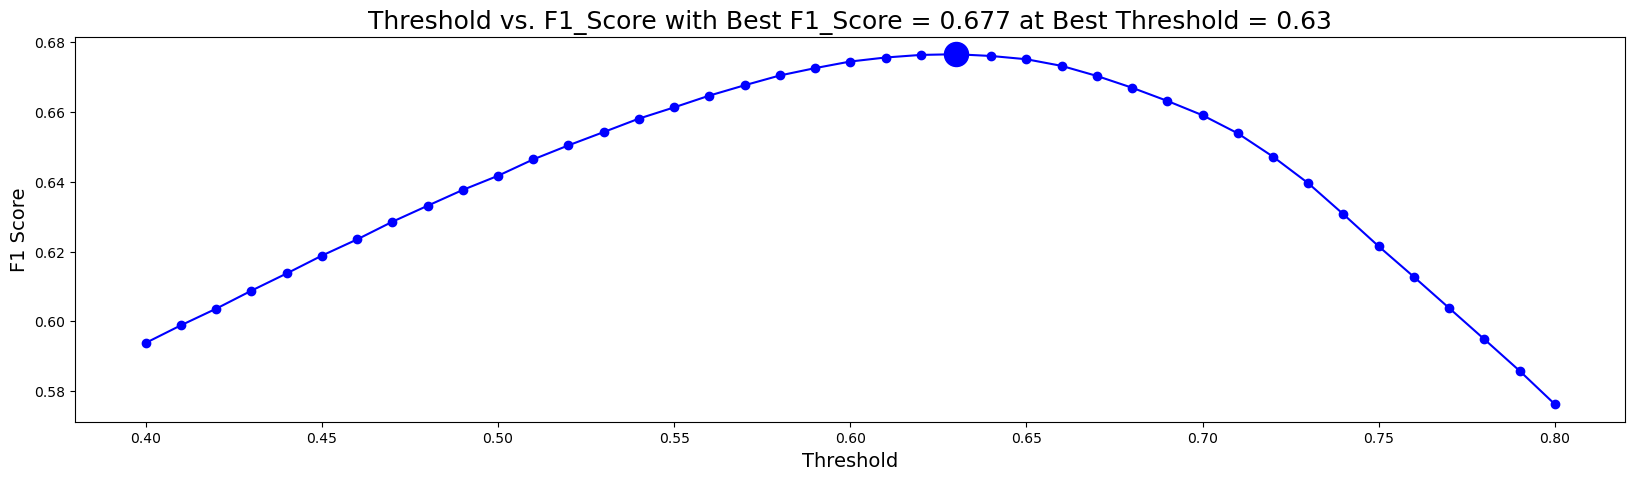

In [27]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [28]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5939042187741084
Q1: F1 = 0.4945936668669012
Q2: F1 = 0.4885585107441168
Q3: F1 = 0.5479319035607266
Q4: F1 = 0.5613938834640069
Q5: F1 = 0.6093309483827324
Q6: F1 = 0.5915376418704729
Q7: F1 = 0.5289688866100604
Q8: F1 = 0.6040180756646938
Q9: F1 = 0.502984931809264
Q10: F1 = 0.5931196681974658
Q11: F1 = 0.49610501048311995
Q12: F1 = 0.44462781632097453
Q13: F1 = 0.610038349985836
Q14: F1 = 0.5068607209459277
Q15: F1 = 0.4529035000467382
Q16: F1 = 0.541762328033037
Q17: F1 = 0.49394125807793826
==> Overall F1 = 0.6765863786591633
